Setup and Library Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install deepface scikit-learn matplotlib


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00


Load and Preview Face Dataset

✅ Total images found: 160


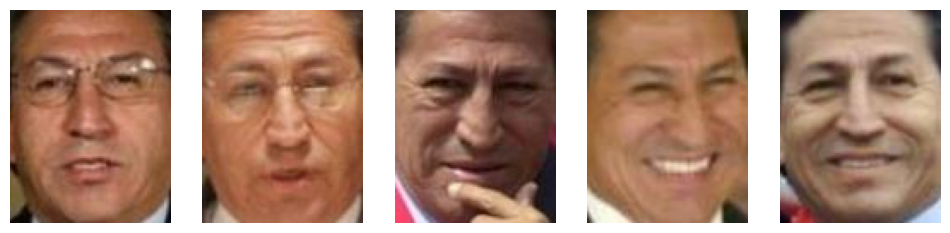

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Dataset path
dataset_path = "/content/drive/MyDrive/lfw_subset_small"

# Collect image paths
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

print("✅ Total images found:", len(image_paths))

# Preview few images
plt.figure(figsize=(12,6))
for i, img_path in enumerate(image_paths[:5]):
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()


Feature Extraction Using DeepFace (Facenet Embeddings)

In [ ]:
from deepface import DeepFace
import numpy as np

embeddings = []

for img_path in image_paths:
    try:
        result = DeepFace.represent(img_path=img_path,
                                    model_name="Facenet",
                                    enforce_detection=True)
        embeddings.append(result[0]["embedding"])
    except Exception as e:
        print(f"Skipping {img_path}, error: {e}")

embeddings = np.array(embeddings)
print("✅ Embeddings shape:", embeddings.shape)


25-10-22 15:05:10 - Directory /root/.deepface has been created
25-10-22 15:05:10 - Directory /root/.deepface/weights has been created


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5


25-10-22 15:05:18 - 🔗 facenet_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5 to /root/.deepface/weights/facenet_weights.h5...


100%|██████████| 92.2M/92.2M [00:00<00:00, 232MB/s]


✅ Embeddings shape: (160, 128)


Visualize Embeddings in 2D (PCA Projection)

Each embedding length: 128


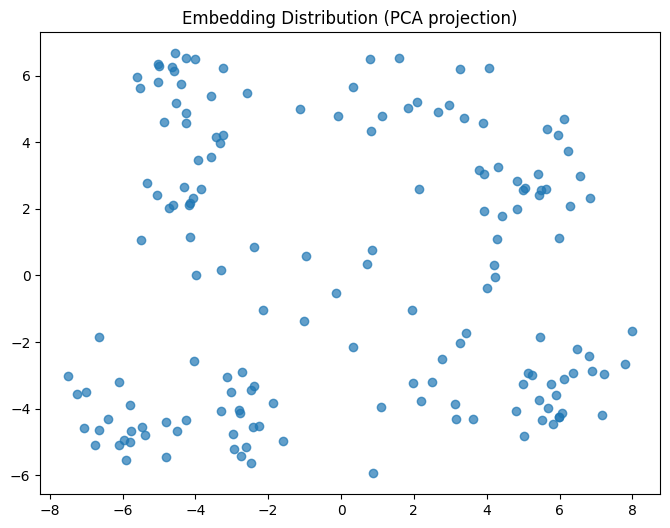

In [ ]:
from sklearn.decomposition import PCA

# Embedding length
print("Each embedding length:", len(embeddings[0]))

# PCA visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.7)
plt.title("Embedding Distribution (PCA projection)")
plt.show()


Prepare Ground Truth Labels for Evaluation

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Get the folder name for each image (which is the person's name)
ground_truth_names = [path.split('/')[-2] for path in image_paths]

# Convert the list of names into integer labels
le = LabelEncoder()
ground_truth_labels = le.fit_transform(ground_truth_names)

print("Ground truth labels created successfully.")
print(f"Found {len(np.unique(ground_truth_labels))} unique individuals.")

Ground truth labels created successfully.
Found 8 unique individuals.


Apply K-Means Clustering

In [ ]:
#KMEANS
from sklearn.cluster import KMeans

k = 8  # adjust depending on how many unique people you expect
kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
labels = kmeans.labels_

print("✅ KMeans produced", len(set(labels)), "clusters")


✅ KMeans produced 8 clusters


Apply DBSCAN Clustering

In [ ]:
#clusters-0
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.6, min_samples=2, metric="euclidean").fit(embeddings)
labels = clustering.labels_

print("✅ Number of clusters found:", len(set(labels)) - (1 if -1 in labels else 0))
print("✅ Noise points:", list(labels).count(-1))


✅ Number of clusters found: 0
✅ Noise points: 160


Tune DBSCAN (ε Parameter)

In [ ]:
#tuned DBSCAN eps
from sklearn.cluster import DBSCAN

# Try multiple eps values to see what works
for eps in [0.6, 0.8, 1.0, 1.2, 1.5, 2.0]:
    clustering = DBSCAN(eps=eps, min_samples=2, metric="euclidean").fit(embeddings)
    labels = clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps={eps:.1f} → clusters={n_clusters}, noise={n_noise}")


eps=0.6 → clusters=0, noise=160
eps=0.8 → clusters=0, noise=160
eps=1.0 → clusters=0, noise=160
eps=1.2 → clusters=0, noise=160
eps=1.5 → clusters=0, noise=160
eps=2.0 → clusters=0, noise=160


Apply HDBSCAN on Raw Embeddings

In [ ]:
!pip install hdbscan -q

In [ ]:
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("--- Evaluating HDBSCAN (on Raw Embeddings) ---")

# Initialize HDBSCAN
# 'min_cluster_size' is the most important parameter.
# It's the smallest size a group can be to be considered a "cluster".
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')

# Fit and get the labels
hdbscan_labels = clusterer.fit_predict(embeddings)

# --- Evaluation ---
n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise = list(hdbscan_labels).count(-1)

# Calculate ARI and NMI
ari_score = adjusted_rand_score(ground_truth_labels, hdbscan_labels)
nmi_score = normalized_mutual_info_score(ground_truth_labels, hdbscan_labels)

print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise} (out of {len(hdbscan_labels)})")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
print("---------------------------------------------")

--- Evaluating HDBSCAN (on Raw Embeddings) ---
Clusters found: 7
Noise points: 25 (out of 160)
Adjusted Rand Index (ARI): 0.8317
Normalized Mutual Information (NMI): 0.8904
---------------------------------------------


Evaluate HDBSCAN on PCA-Reduced Embeddings

In [ ]:
from sklearn.decomposition import PCA

print("\n--- Evaluating HDBSCAN (on PCA-Reduced Embeddings) ---")

# First, reduce the embeddings using PCA
# n_components=0.95 means PCA will keep the number of components
# needed to preserve 95% of the variance.
pca = PCA(n_components=0.95)
reduced_embeddings = pca.fit_transform(embeddings)

print(f"Original dimensions: {embeddings.shape[1]}")
print(f"Reduced dimensions: {reduced_embeddings.shape[1]}")

# Now, run HDBSCAN on the reduced data
clusterer_pca = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
hdbscan_labels_pca = clusterer_pca.fit_predict(reduced_embeddings)

# --- Evaluation ---
n_clusters_pca = len(set(hdbscan_labels_pca)) - (1 if -1 in hdbscan_labels_pca else 0)
n_noise_pca = list(hdbscan_labels_pca).count(-1)

# Calculate ARI and NMI
ari_score_pca = adjusted_rand_score(ground_truth_labels, hdbscan_labels_pca)
nmi_score_pca = normalized_mutual_info_score(ground_truth_labels, hdbscan_labels_pca)

print(f"Clusters found (PCA): {n_clusters_pca}")
print(f"Noise points (PCA): {n_noise_pca}")
print(f"Adjusted Rand Index (ARI) (PCA): {ari_score_pca:.4f}")
print(f"Normalized Mutual Information (NMI) (PCA): {nmi_score_pca:.4f}")
print("---------------------------------------------")


--- Evaluating HDBSCAN (on PCA-Reduced Embeddings) ---
Original dimensions: 128
Reduced dimensions: 35
Clusters found (PCA): 7
Noise points (PCA): 18
Adjusted Rand Index (ARI) (PCA): 0.7453
Normalized Mutual Information (NMI) (PCA): 0.8369
---------------------------------------------


Evaluate Clustering Performance (ARI & NMI Comparison)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("--- Evaluating Your Original MVP K-Means (k=8, no n_init) ---")

# --- Your original K-Means code ---
k = 8
kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
old_kmeans_labels = kmeans.labels_
# ---

# --- Evaluation ---
ari_score = adjusted_rand_score(ground_truth_labels, old_kmeans_labels)
nmi_score = normalized_mutual_info_score(ground_truth_labels, old_kmeans_labels)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
print("--------------------------------------------------")

--- Evaluating Your Original MVP K-Means (k=8, no n_init) ---
Adjusted Rand Index (ARI): 0.8149
Normalized Mutual Information (NMI): 0.9199
--------------------------------------------------


Visualize Cluster Results (PCA Projection)

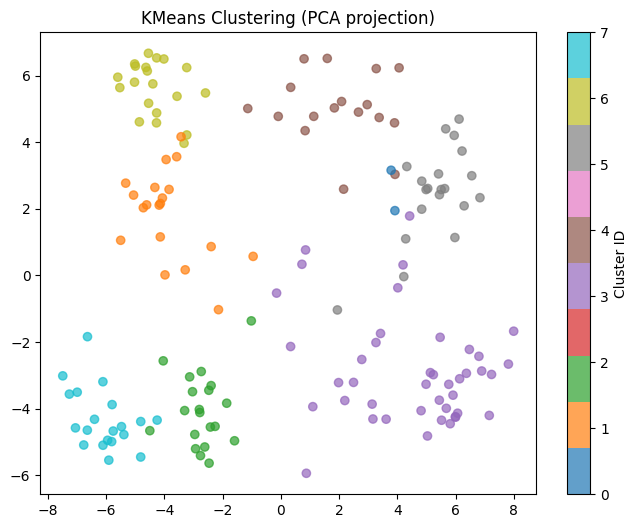

In [ ]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.title("KMeans Clustering (PCA projection)")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

Inspect Sample Faces from Each Cluster

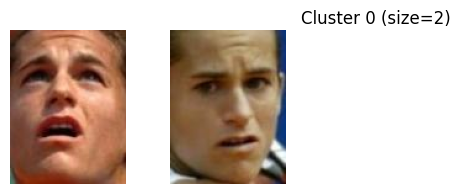

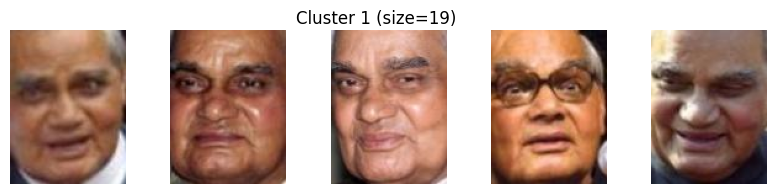

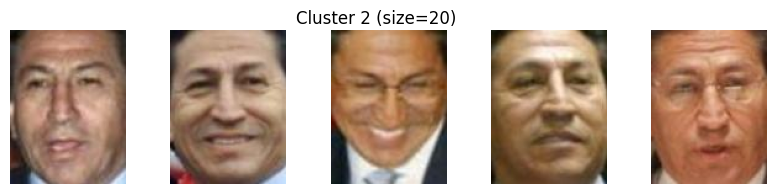

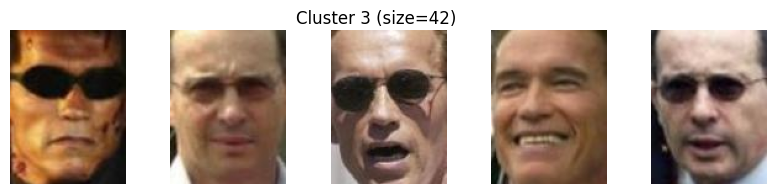

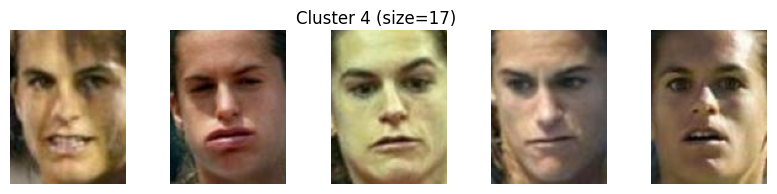

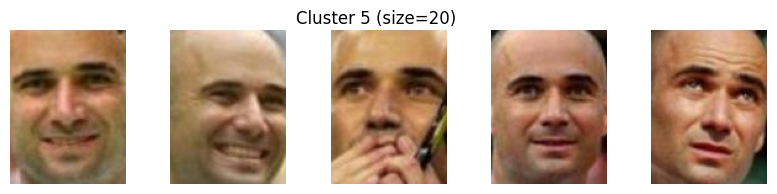

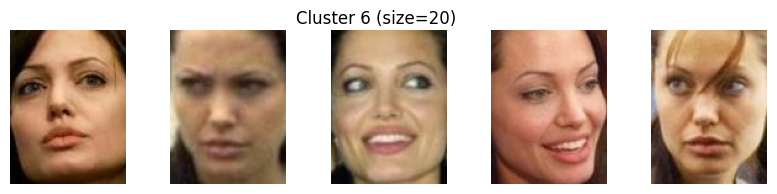

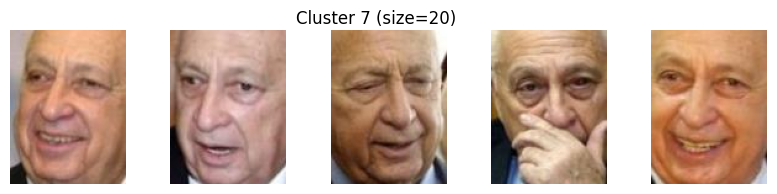

In [ ]:
import random

# Pick a few clusters to visualize
for cluster_id in range(k):
    cluster_indices = [i for i, lbl in enumerate(labels) if lbl == cluster_id]

    if len(cluster_indices) == 0:
        continue

    # Sample up to 5 images from this cluster
    sample_indices = random.sample(cluster_indices, min(5, len(cluster_indices)))

    plt.figure(figsize=(10,2))
    plt.suptitle(f"Cluster {cluster_id} (size={len(cluster_indices)})")

    for i, idx in enumerate(sample_indices):
        img = Image.open(image_paths[idx])
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

print("\n--- Evaluating Your Original DBSCAN Attempts ---")

for eps in [0.6, 0.8, 1.0, 1.2, 1.5, 2.0]:
    # --- Your original DBSCAN code ---
    clustering = DBSCAN(eps=eps, min_samples=2, metric="euclidean").fit(embeddings)
    dbscan_labels = clustering.labels_
    # ---

    # --- Evaluation ---
    ari_score = adjusted_rand_score(ground_truth_labels, dbscan_labels)
    nmi_score = normalized_mutual_info_score(ground_truth_labels, dbscan_labels)

    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    print(f"eps={eps:.1f} → clusters={n_clusters}, noise={n_noise} | ARI: {ari_score:.4f} | NMI: {nmi_score:.4f}")

print("---------------------------------------------")


--- Evaluating Your Original DBSCAN Attempts ---
eps=0.6 → clusters=0, noise=160 | ARI: 0.0000 | NMI: 0.0000
eps=0.8 → clusters=0, noise=160 | ARI: 0.0000 | NMI: 0.0000
eps=1.0 → clusters=0, noise=160 | ARI: 0.0000 | NMI: 0.0000
eps=1.2 → clusters=0, noise=160 | ARI: 0.0000 | NMI: 0.0000
eps=1.5 → clusters=0, noise=160 | ARI: 0.0000 | NMI: 0.0000
eps=2.0 → clusters=0, noise=160 | ARI: 0.0000 | NMI: 0.0000
---------------------------------------------


Appendix Cells


A1: Organize Clustered Images into Folders

In [ ]:
import shutil

output_dir = "/content/drive/MyDrive/lfw_clusters"
os.makedirs(output_dir, exist_ok=True)

for label, img_path in zip(labels, image_paths):
    if label == -1:
        cluster_folder = os.path.join(output_dir, "unknown")
    else:
        cluster_folder = os.path.join(output_dir, f"person_{label}")
    os.makedirs(cluster_folder, exist_ok=True)
    shutil.copy(img_path, cluster_folder)

print("✅ Clustered folders created at:", output_dir)


In [ ]:
import os, shutil, zipfile
import random

# ✅ Step 1: Organize clustered images into folders
output_dir = "/content/drive/MyDrive/lfw_clusters"
os.makedirs(output_dir, exist_ok=True)

for label, img_path in zip(labels, image_paths):
    cluster_folder = os.path.join(output_dir, f"person_{label}")
    os.makedirs(cluster_folder, exist_ok=True)
    shutil.copy(img_path, cluster_folder)

print("✅ Clustered folders created at:", output_dir)

# ✅ Step 2: Simulate assigning names (prompted or auto)
unique_labels = set(labels)
name_map = {label: f"Person_{i+1}" for i, label in enumerate(unique_labels)}

print("✅ Assigned Names:", name_map)

# ✅ Step 3: Zip each cluster
zip_output_dir = os.path.join(output_dir, "zipped_clusters")
os.makedirs(zip_output_dir, exist_ok=True)

for label in unique_labels:
    folder = os.path.join(output_dir, f"person_{label}")
    zip_path = os.path.join(zip_output_dir, f"{name_map[label]}.zip")

    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for root, _, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, arcname=file)  # arcname avoids full paths inside zip

    print(f"✅ Zipped {folder} → {zip_path}")

# ✅ Step 4: Simulate dispatch by creating a report
dispatch_report = os.path.join(zip_output_dir, "dispatch_report.txt")

with open(dispatch_report, "w") as f:
    for label, name in name_map.items():
        zip_path = os.path.join(zip_output_dir, f"{name}.zip")
        f.write(f"{name} → {zip_path}\n")

print("✅ Dispatch simulation complete! Report saved at:", dispatch_report)

# ✅ Step 5: Quick summary (cluster sizes)
for label in unique_labels:
    cluster_folder = os.path.join(output_dir, f"person_{label}")
    print(f"Cluster {label} ({name_map[label]}): {len(os.listdir(cluster_folder))} images")


A2: Assign Simulated Names to Clusters

In [ ]:
unique_labels = set([l for l in labels if l != -1])

# Simulated mapping: person_X → Name
name_map = {label: f"Person_{i+1}" for i, label in enumerate(unique_labels)}

print("✅ Assigned Names:", name_map)


A3: Generate Dispatch Report

In [ ]:
dispatch_report = os.path.join(output_dir, "dispatch_report.txt")

with open(dispatch_report, "w") as f:
    for label, name in name_map.items():
        folder = os.path.join(output_dir, f"person_{label}")
        f.write(f"{name} → {folder}\n")

print("✅ Dispatch report saved:", dispatch_report)
